## Overview
In the experimental, I show how to build a recommand model for Movie Recommendation based on MovieLens 100K data set.
MovieLens data sets were collected over various periods of time, depending on the size of the set. MovieLens 100K movie ratings. Stable benchmark dataset. 100,000 ratings from 1000 users on 1700 movies. Released on 4/1998.

## Setup
Let's first install necessary libraries and get our imports out of the way.

In [1]:
!pip install --upgrade tensorflow-datasets tensorflow-recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 40.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.9.2
    Uninstalling tensorflow-datasets-4.9.2:
      Successfully uninstalled tensorflow-datasets-4.9.2


In [2]:
from typing import Dict, Text

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.model_selection import train_test_split

## Preparing the dataset

I load the dataset via tensorflow dataset directly which transfer the dataset into a tensorflow record format. It's free and available online.

In [73]:
ratings = tfds.load("movielens/100k-ratings", split="train")

For convinence, I convert the dataset to a pandas dataframe format for visual dataset. In order to finish converting, I convert genres from array to string format.

In [4]:
def replace_genres(x):
    x['movie_genres'] = tf.strings.reduce_join(tf.strings.as_string(x['movie_genres']), axis=-1, separator='_')
    return x
pd_ds = ratings.map(replace_genres).batch(100000)
train_dict = next(iter(pd_ds))
df = pd.DataFrame.from_dict(train_dict)

According to ```info``` function, there are 100000 samples without null object in the dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   bucketized_user_age    100000 non-null  float32
 1   movie_genres           100000 non-null  object 
 2   movie_id               100000 non-null  object 
 3   movie_title            100000 non-null  object 
 4   raw_user_age           100000 non-null  float32
 5   timestamp              100000 non-null  int64  
 6   user_gender            100000 non-null  bool   
 7   user_id                100000 non-null  object 
 8   user_occupation_label  100000 non-null  int64  
 9   user_occupation_text   100000 non-null  object 
 10  user_rating            100000 non-null  float32
 11  user_zip_code          100000 non-null  object 
dtypes: bool(1), float32(3), int64(2), object(6)
memory usage: 7.3+ MB


As ```head``` function shows, there are several class features such as ```user_occupation_text```, ```movie_genres```, ```movie_id``` and ```user_zip_code```. I have to convert them to int features by ```StringLookup``` or ```IntegerLookup``` for training the model.

In [6]:
df.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,b'7',b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,b'4_14',b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,b'4',b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,b'5_7',b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,b'10_16',b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'


In order to display time infomation in a normal format, I convert timestamp to datetime format.

In [7]:
def to_datetime(x):
    x['year_month'] = datetime.fromtimestamp(x['timestamp']).strftime("%Y-%m")
    return x
df = df.apply(to_datetime, axis=1)

The plot shows rating counts in different months.

<Axes: xlabel='year_month'>

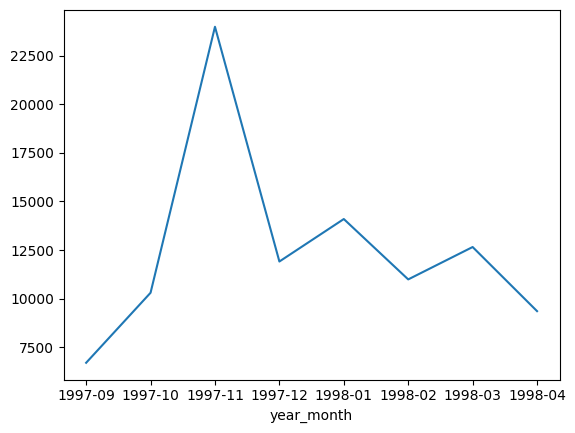

In [8]:
df['year_month'].value_counts().sort_index().plot(kind='line')

The bar chart shows 4 is most common rating value and rating values are always integers.

<Axes: xlabel='user_rating'>

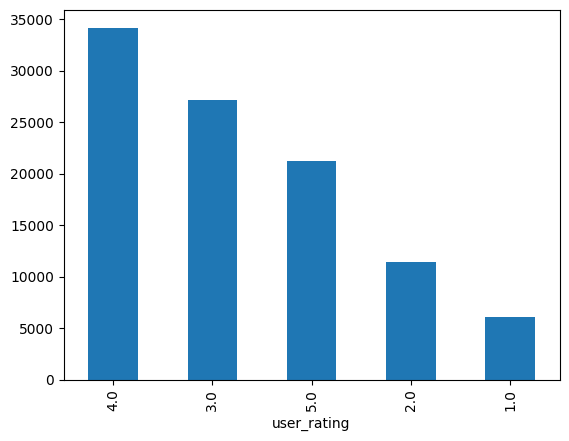

In [9]:
df['user_rating'].value_counts().plot(kind='bar')

The bar chart shows relationship between different occupation and rating counts.

<Axes: xlabel='user_occupation_text'>

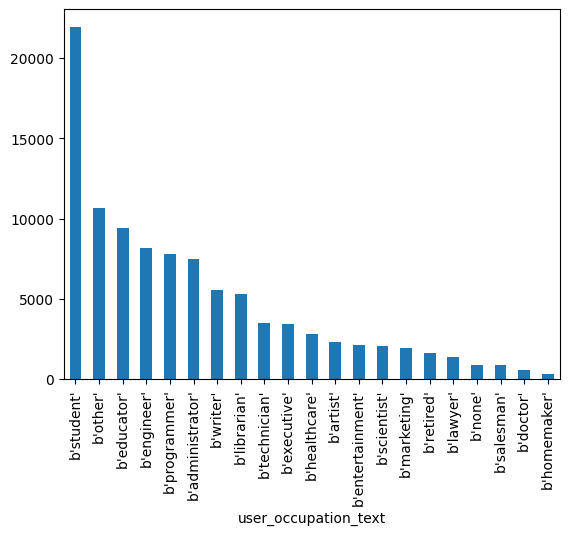

In [10]:
df['user_occupation_text'].value_counts().plot(kind='bar')

The majority of users who rates movies are between 25-34.
There are age ranges of different bucketized user ages.

1: "Under 18"

18: "18-24"

25: "25-34"

35: "35-44"

45: "45-49"

50: "50-55"

56: "56+"

<Axes: xlabel='bucketized_user_age'>

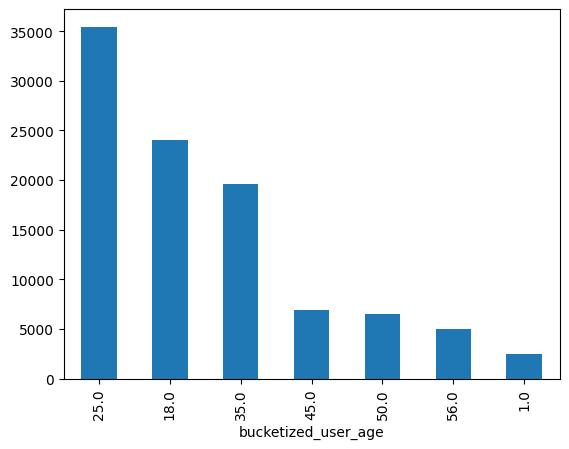

In [11]:
df['bucketized_user_age'].value_counts().plot(kind='bar')

The plot shows the relationship between rating number and rating means.

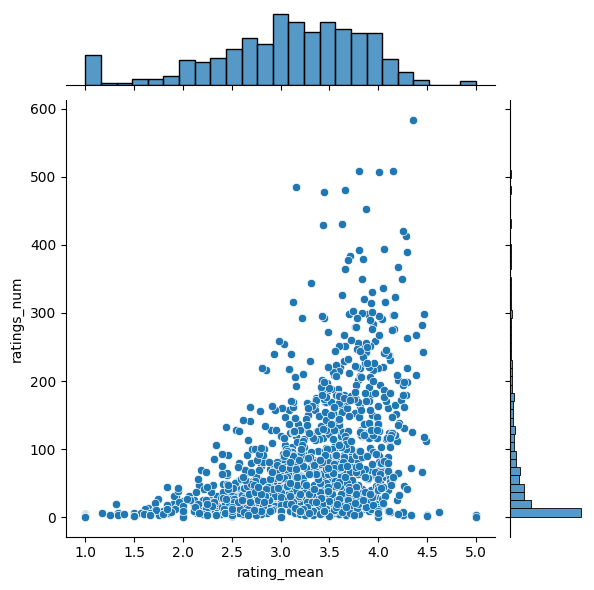

In [12]:
ratings_joint = pd.DataFrame()
ratings_joint["rating_mean"] = df.groupby("movie_title")['user_rating'].mean()
ratings_joint['ratings_num'] = df.groupby("movie_title")["user_rating"].count()
sns.jointplot(x='rating_mean', y='ratings_num', data=ratings_joint)

I also draw a correlation matrix helps me to select useful features. According to heatmap, these features have similar importance. 

<Axes: >

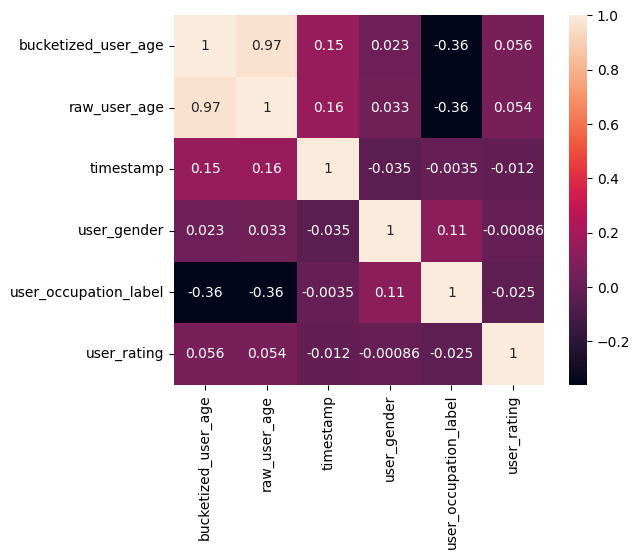

In [13]:
sns.heatmap(df.corr(numeric_only=True), square=True, annot=True)

I select 80000 samples as train dataset and 20000 samples as test dataset. In order to get same output shape of different rows, I convert movie genres, array like feature, to a multi hot feature, each row has same output shape which correspond to movie genres class count plus 1. 

In [74]:
num_tokens = df['movie_genres'].apply(lambda x: x.decode('utf-8').split('_')).explode(ignore_index=True).nunique()
movie_genres_encoder = tf.keras.layers.CategoryEncoding(num_tokens=num_tokens+1, output_mode="multi_hot")

def preprocess(x):
    x["movie_genres"] = movie_genres_encoder(x["movie_genres"])
    x["user_gender"] = tf.cast(x["user_gender"], tf.float32)
    return x

ratings = ratings.map(preprocess)

shuffled = ratings.shuffle(100000, reshuffle_each_iteration=False)

train = shuffled.take(80000)
test = shuffled.skip(80000).take(20000)

train_dataset = train.batch(1024).shuffle(10000).cache()
test_dataset = test.batch(1024).cache()

## Implementing a simple model

In the first approach, I employ user zip codes, movie genres, user gender, user age and user occupation label as inputs, some inputs follow a embedding layer in order to reduce output dimensions. Finally I concat these features into a tensor and put them into a MLP, which predicts rating values. In the model, I use MSE as loss and RMSE as metric. Since sigmoid produce float values but the labels is integer values, so I employ round these values to nearest integer, then I clip these values in range 0 and 5 to ensure the outputs correct values when the model is doing inference.

In the follow steps, I use ```StringLoopup``` and ```IntegerLookup```  translates a set of arbitrary values into contiguous ranges.

In [75]:
unique_movie_ids = tf.keras.layers.StringLookup(vocabulary=df["movie_id"].unique(), mask_token=None, num_oov_indices=0)
unique_user_zip_codes = tf.keras.layers.StringLookup(vocabulary=df["user_zip_code"].unique(), mask_token=None, num_oov_indices=0)
unique_occupation_label = tf.keras.layers.IntegerLookup(vocabulary=df["user_occupation_label"].unique(), mask_token=None, num_oov_indices=0)

I do following steps in order to get a initial value that is used in a embedding which could gain movie genres from movie ids.

In [76]:
movie_group = df.groupby("movie_id")
movie_group = pd.DataFrame(
    data={
        "movie_id": movie_group.movie_id.first(),
        "movie_genres": movie_group.movie_genres.first(),
    }
)

movie_group["movie_genres"] = movie_group['movie_genres'].apply(lambda x: x.decode('utf-8').split('_'))
genres = movie_group["movie_genres"].explode(ignore_index=True).unique()
for genre in genres:
    movie_group[genre] = movie_group["movie_genres"].apply(
        lambda values: int(genre in values)
    )
movie_genres_multi_hot = movie_group[genres].to_numpy()

This is base model, the majority part of the model without training related codes.

In [77]:
class RankingModel(tf.keras.Model):

    def __init__(self, dense_unit=512, using_user_zip_codes=True, using_movie_genres=True, using_user_occupation_label=True, using_user_gender=True, using_user_age=True):
        super().__init__()
        embedding_dimension = 32
        
        self.using_user_zip_codes = using_user_zip_codes
        self.using_movie_genres = using_movie_genres
        self.using_user_occupation_label = using_user_occupation_label
        self.using_user_gender = using_user_gender
        self.using_user_age = using_user_age
        
        # Compute embeddings for users.
        self.user_zip_code_embeddings = tf.keras.Sequential([
            unique_user_zip_codes,
            tf.keras.layers.Embedding(unique_user_zip_codes.vocabulary_size() + 1, embedding_dimension)
        ], name="user_zip_code_embeddings")

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.layers.Embedding(unique_movie_ids.vocabulary_size() + 1, embedding_dimension, name="movie_embeddings")

        self.movie_genres_embeddings = tf.keras.layers.Embedding(
            input_dim=movie_genres_multi_hot.shape[0],
            output_dim=movie_genres_multi_hot.shape[1],
            embeddings_initializer=tf.keras.initializers.Constant(movie_genres_multi_hot),
            trainable=False,
            name="movie_genres_embeddings",
        )

        self.user_occupation_label_embeddings = tf.keras.Sequential([
            unique_occupation_label,
            tf.keras.layers.Embedding(unique_occupation_label.vocabulary_size() + 1, 8)
        ], name="user_occupation_label_embeddings")

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
            # Learn multiple dense layers.
            tf.keras.layers.Dense(dense_unit, activation="relu"),
            tf.keras.layers.Dense(dense_unit//4, activation="relu"),
            # Make rating predictions in the final layer.
            tf.keras.layers.Dense(1)
        ], name="ratings")

    def call(self, inputs, training=False):

        user_zip_code, movie_id, user_age, user_occupation_label, user_gender = inputs
        
        features = []
        if self.using_user_zip_codes:
            features.append(self.user_zip_code_embeddings(user_zip_code))
        movie_id = unique_movie_ids(movie_id)
        features.append(self.movie_embeddings(movie_id))
        if self.using_movie_genres:
            features.append(self.movie_genres_embeddings(movie_id))
        if self.using_user_occupation_label:
            features.append(self.user_occupation_label_embeddings(user_occupation_label))

        if self.using_user_gender:
            features.append(tf.expand_dims(user_gender, axis=-1))
        if self.using_user_age:
            features.append(tf.expand_dims(user_age, axis=-1))

        res = tf.squeeze(self.ratings(tf.concat(features, axis=1)), axis=-1)
        return res if training else tf.clip_by_value(tf.math.round(res), 0, 5)

Test model with a sample.

In [78]:
example = next(iter(train_dataset))
ranking_model = RankingModel()
ranking_model((example["user_zip_code"], example["movie_id"], example["bucketized_user_age"], example["user_occupation_label"], example["user_gender"]))

<tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

Let's print model parameters and shapes via ```summary```. There are total 225,351 parameters in the model, 193393 parameters are trainable and 31958 parameters are non-trainable.

In [79]:
ranking_model.summary(expand_nested=True)

Model: "ranking_model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_zip_code_embeddings (S  (1024, 32)               25472     
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| string_lookup_9 (StringLook  (1024,)                0         |
| up)                                                           |
|                                                               |
| embedding_28 (Embedding)  (1024, 32)                25472     |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 movie_embeddings (Embedding  multiple                 53856     
 )                                                               
                                                                 
 movie_genres_embeddings (Em  multiple                 31958     
 bedding)                                         

Here is full training model which contains base model and training parts.

In [80]:
class MovielensModel(tfrs.models.Model):
    def __init__(self, dense_units=512, using_user_zip_codes=True, using_movie_genres=True, using_user_occupation_label=True, using_user_gender=True, using_user_age=True):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel(dense_units, using_user_zip_codes, using_movie_genres, using_user_occupation_label, using_user_gender, using_user_age)
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
          loss = tf.keras.losses.MeanSquaredError(),
          metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        return self.ranking_model(
            (features["user_zip_code"], features["movie_id"], features["bucketized_user_age"], features["user_occupation_label"], features["user_gender"]))

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        labels = features.pop("user_rating")

        rating_predictions = self(features, training=True)
        return self.task(labels=labels, predictions=rating_predictions)

## Fitting and evaluating


Let's first instantiate the model.

In [81]:
def build_model(learning_rate=0.1, dense_units=512, using_user_zip_codes=True, using_movie_genres=True, using_user_occupation_label=True, using_user_gender=True, using_user_age=True):
    model = MovielensModel(dense_units, using_user_zip_codes, using_movie_genres, using_user_occupation_label, using_user_gender, using_user_age)
    model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate))
    model.build(tf.nest.map_structure(lambda x: x.shape, example))
    return model

model = build_model()

Train the  model 10 epochs.

In [82]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
79/79 [==============================] - 26s 210ms/step - root_mean_squared_error: 49.4237 - loss: 2385.4805 - regularization_loss: 0.0000e+00 - total_loss: 2385.4805 - val_root_mean_squared_error: 1.1747 - val_loss: 1.4919 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.4919
Epoch 2/10
79/79 [==============================] - 1s 7ms/step - root_mean_squared_error: 1.1319 - loss: 1.2775 - regularization_loss: 0.0000e+00 - total_loss: 1.2775 - val_root_mean_squared_error: 1.1219 - val_loss: 1.3243 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3243
Epoch 3/10
79/79 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.0821 - loss: 1.1667 - regularization_loss: 0.0000e+00 - total_loss: 1.1667 - val_root_mean_squared_error: 1.0605 - val_loss: 1.1784 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1784
Epoch 4/10
79/79 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.0294 - loss: 1.0563 - regularizat

Let's plot training logs, according to visual plot, the model is underfitting and I should train the model with more epochs.

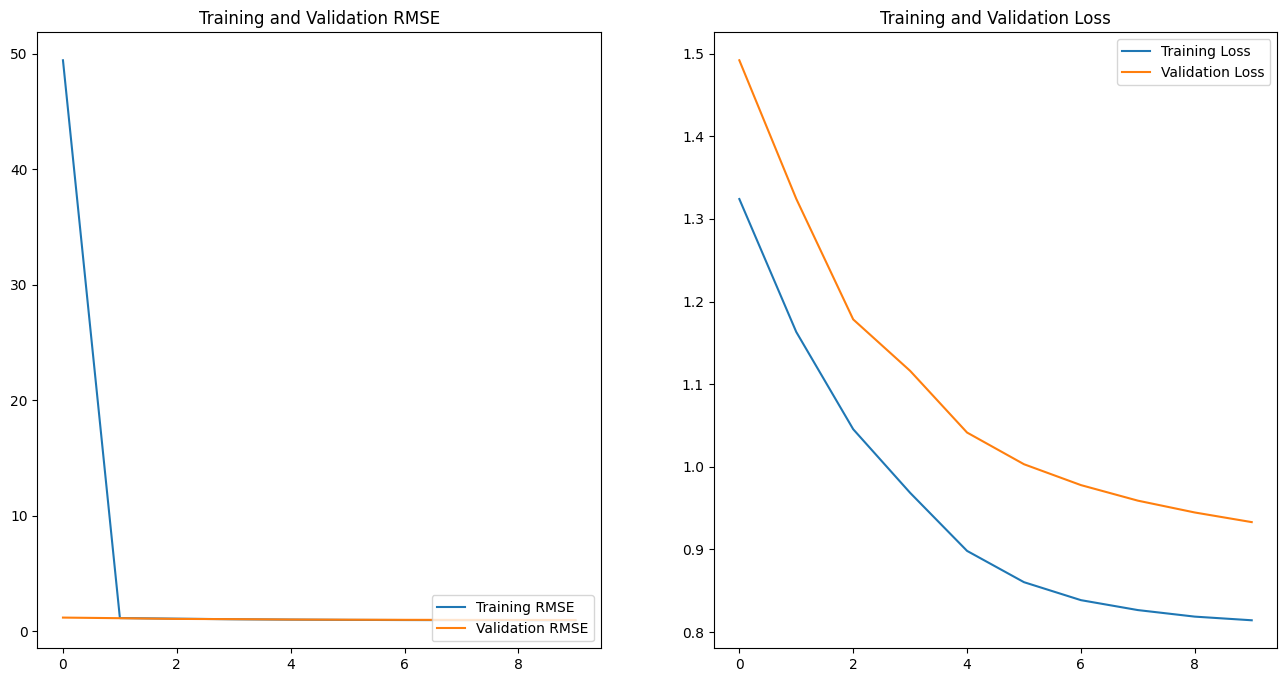

In [83]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training RMSE')
plt.plot(epochs_range, val_rmse, label='Validation RMSE')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Implementing a transformer model

In the approach, I try to explore the timestamp usage in the dataset. I set 4 movie ids and 4 user ratings as sequences, predicting last value from previous three values. I add transformer as a sequence encoder then put transformer outputs into a MLP. The rest parts are similar to the simple model. 

Before train the model, I preprocess the dataset and add two new features, ```sequence_user_ratings``` and ```sequence_movie_ids```. Firstly, I sort the dataset by timestamp and group the dataset by user id.

In [108]:
ratings_group = df.sort_values(by=["timestamp"]).groupby("user_id")
ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "movie_ids": list(ratings_group.movie_id.apply(list)),
        "user_ratings": list(ratings_group.user_rating.apply(list)),
        "timestamps": list(ratings_group.timestamp.apply(list)),
        "user_zip_code": ratings_group.user_zip_code.first(),
        "user_gender": ratings_group.user_gender.first(),
        "bucketized_user_age": ratings_group.bucketized_user_age.first(),
        "user_occupation_label": ratings_group.user_occupation_label.first()
    }
)
ratings_data.head()

,user_id,movie_ids,user_ratings,timestamps,user_zip_code,user_gender,bucketized_user_age,user_occupation_label
user_id,,,,,,,,
b'1',b'1',"[b'172', b'168', b'165', b'156', b'166', b'196...","[5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 4.0, 5.0, ...","[874965478, 874965478, 874965518, 874965556, 8...",b'85711',True,18.0,18
b'10',b'10',"[b'302', b'269', b'286', b'289', b'319', b'245...","[4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, ...","[877886162, 877886162, 877886162, 877886223, 8...",b'90703',True,50.0,9
b'100',b'100',"[b'333', b'302', b'288', b'269', b'258', b'313...","[3.0, 4.0, 2.0, 4.0, 4.0, 5.0, 3.0, 4.0, 4.0, ...","[891374528, 891374528, 891374603, 891374641, 8...",b'90254',True,35.0,6
b'101',b'101',"[b'304', b'282', b'846', b'50', b'7', b'280', ...","[3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 4.0, 3.0, ...","[877135677, 877135883, 877135914, 877135944, 8...",b'05146',True,1.0,17
b'102',b'102',"[b'258', b'300', b'319', b'298', b'248', b'326...","[4.0, 3.0, 4.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, ...","[875886337, 875886434, 875886434, 875886827, 8...",b'30220',True,35.0,12


In [109]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 943 entries, b'1' to b'99'
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                943 non-null    object 
 1   movie_ids              943 non-null    object 
 2   user_ratings           943 non-null    object 
 3   timestamps             943 non-null    object 
 4   user_zip_code          943 non-null    object 
 5   user_gender            943 non-null    bool   
 6   bucketized_user_age    943 non-null    float64
 7   user_occupation_label  943 non-null    int64  
dtypes: bool(1), float64(1), int64(1), object(5)
memory usage: 92.1+ KB


In the current implementation, I set sequence length is 4 and step size is 2.

In [110]:
sequence_length = 4
step_size = 2

def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences

def create_sequences_fn(row):
    row['movie_ids'] = create_sequences(row['movie_ids'], sequence_length, step_size)
    row['user_ratings'] = create_sequences(row['user_ratings'], sequence_length, step_size)
    return row

ratings_data = ratings_data.apply(create_sequences_fn, axis=1)

Expand movie ids in first dimension, each row only has a movie ids array which contains 4 movie ids.

In [111]:
ratings_data_movies = ratings_data[["user_id", "movie_ids"]].explode(
    "movie_ids", ignore_index=True
)
ratings_data_rating = ratings_data[["user_ratings"]].explode("user_ratings", ignore_index=True)

ratings_data_transformed = pd.concat([ratings_data_movies, ratings_data_rating], axis=1)
ratings_data_transformed = ratings_data_transformed.join(ratings_data.set_index("user_id"), on="user_id", rsuffix='_')

ratings_data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49760 entries, 0 to 49759
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                49760 non-null  object 
 1   movie_ids              49760 non-null  object 
 2   user_ratings           49760 non-null  object 
 3   movie_ids_             49760 non-null  object 
 4   user_ratings_          49760 non-null  object 
 5   timestamps             49760 non-null  object 
 6   user_zip_code          49760 non-null  object 
 7   user_gender            49760 non-null  bool   
 8   bucketized_user_age    49760 non-null  float64
 9   user_occupation_label  49760 non-null  int64  
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 3.5+ MB


In [112]:
ratings_data_transformed.head()

,user_id,movie_ids,user_ratings,movie_ids_,user_ratings_,timestamps,user_zip_code,user_gender,bucketized_user_age,user_occupation_label
0,b'1',"[b'172', b'168', b'165', b'156']","[5.0, 5.0, 5.0, 4.0]","[[b'172', b'168', b'165', b'156'], [b'165', b'...","[[5.0, 5.0, 5.0, 4.0], [5.0, 4.0, 5.0, 5.0], [...","[874965478, 874965478, 874965518, 874965556, 8...",b'85711',True,18.0,18
1,b'1',"[b'165', b'156', b'166', b'196']","[5.0, 4.0, 5.0, 5.0]","[[b'172', b'168', b'165', b'156'], [b'165', b'...","[[5.0, 5.0, 5.0, 4.0], [5.0, 4.0, 5.0, 5.0], [...","[874965478, 874965478, 874965518, 874965556, 8...",b'85711',True,18.0,18
2,b'1',"[b'166', b'196', b'187', b'250']","[5.0, 5.0, 4.0, 4.0]","[[b'172', b'168', b'165', b'156'], [b'165', b'...","[[5.0, 5.0, 5.0, 4.0], [5.0, 4.0, 5.0, 5.0], [...","[874965478, 874965478, 874965518, 874965556, 8...",b'85711',True,18.0,18
3,b'1',"[b'187', b'250', b'127', b'14']","[4.0, 4.0, 5.0, 5.0]","[[b'172', b'168', b'165', b'156'], [b'165', b'...","[[5.0, 5.0, 5.0, 4.0], [5.0, 4.0, 5.0, 5.0], [...","[874965478, 874965478, 874965518, 874965556, 8...",b'85711',True,18.0,18
4,b'1',"[b'127', b'14', b'181', b'117']","[5.0, 5.0, 5.0, 3.0]","[[b'172', b'168', b'165', b'156'], [b'165', b'...","[[5.0, 5.0, 5.0, 4.0], [5.0, 4.0, 5.0, 5.0], [...","[874965478, 874965478, 874965518, 874965556, 8...",b'85711',True,18.0,18


I split dataset into two parts, training dataset has 80000 samples and test dataset has 20000 samples.

In [113]:
train, test = train_test_split(ratings_data_transformed.drop(columns=["movie_ids_", "user_ratings_"]), test_size=0.2)

In [114]:
def data_gen(df):
    def _exec():
        for (idx, row) in df.iterrows():
            yield (row["user_id"], row["movie_ids"], row["user_ratings"], row["user_zip_code"], row["user_gender"], row["bucketized_user_age"], row["user_occupation_label"])
        
    return _exec
transformer_train_dataset = tf.data.Dataset.from_generator(data_gen(train),
                                                           output_types=(tf.string, tf.string, tf.float32, tf.string, tf.bool, tf.float32, tf.int32),
                                                           output_shapes=((), (4), (4), (), (), (), ()))
transformer_test_dataset = tf.data.Dataset.from_generator(data_gen(test),
                                                          output_types=(tf.string, tf.string, tf.float32, tf.string, tf.bool, tf.float32, tf.int32),
                                                          output_shapes=((), (4), (4), (), (), (), ()))

Split last value from sequence and set it as target value.

In [115]:
def preprocess(user_id, movie_ids, user_ratings, user_zip_code, user_gender, bucketized_user_age, user_occupation_label):
    return {
        "user_id": user_id,
        "sequence_movie_ids": movie_ids[:, :-1],
        "target_movie_id": movie_ids[:, -1],
        "sequence_user_ratings": user_ratings[:, :-1],
        "user_rating": user_ratings[:, -1],
        "user_zip_code": user_zip_code,
        "user_gender": user_gender,
        "bucketized_user_age": bucketized_user_age,
        "user_occupation_label": user_occupation_label,
    }

transformer_train_dataset = transformer_train_dataset.cache().prefetch(1024).batch(1024).map(preprocess)
transformer_test_dataset = transformer_test_dataset.cache().prefetch(1024).batch(1024).map(preprocess)

The model implementation with transformer. In order to prevent model from overfitting, I add some dropout layers in the model.

In [116]:
 class RankingTransformer(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.embedding_dimension = 32
        dropout_rate = 0.1

        # Compute embeddings for users.
        self.user_zip_code_embeddings = tf.keras.Sequential([
            unique_user_zip_codes,
            tf.keras.layers.Embedding(unique_user_zip_codes.vocabulary_size() + 1, self.embedding_dimension)
        ], name="user_zip_code_embeddings")

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.layers.Embedding(unique_movie_ids.vocabulary_size() + 1, self.embedding_dimension, name="movie_embeddings")

        self.movie_genres_embeddings = tf.keras.layers.Embedding(
            input_dim=movie_genres_multi_hot.shape[],
            output_dim=movie_genres_multi_hot.shape[1],
            embeddings_initializer=tf.keras.initializers.Constant(movie_genres_multi_hot),
            trainable=False,
            name="movie_genres_embeddings",
        )

        self.user_occupation_label_embeddings = tf.keras.Sequential([
            unique_occupation_label,
            tf.keras.layers.Embedding(unique_occupation_label.vocabulary_size() + 1, 8)
        ])
        
        movie_embedding_dims = int(unique_movie_ids.vocabulary_size()**0.5)
        self.position_embedding_encoder = tf.keras.layers.Embedding(
            input_dim=sequence_length,
            output_dim=movie_embedding_dims,
            name="position_embedding",
        )
        
        self.movie_embedding_processor = tf.keras.layers.Dense(
            movie_embedding_dims,
            activation="relu",
            name="process_movie_embedding_with_genres",
        )
        # Compute predictions.
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=3, key_dim=41, dropout=dropout_rate)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.dense = tf.keras.layers.Dense(41)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.ratings = tf.keras.Sequential([
            # Learn multiple dense layers.
            tf.keras.layers.Dense(512, activation="leaky_relu"),
            tf.keras.layers.Dense(128, activation="leaky_relu"),
            # Make rating predictions in the final layer.
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(1)
        ], name='rating')
        
    def call(self, inputs, training=False):

        user_zip_code, sequence_movie_ids, target_movie_id, sequence_user_ratings, user_age, user_occupation_label, user_gender = inputs
        
        user_zip_code_embedding = self.user_zip_code_embeddings(user_zip_code)
        
        sequence_movie_ids = unique_movie_ids(sequence_movie_ids)
        sequence_movie_embedding = self.movie_embeddings(sequence_movie_ids)
        sequence_movie_genres_embedding = self.movie_genres_embeddings(sequence_movie_ids)
        sequence_movie_embedding = self.movie_embedding_processor(tf.keras.layers.concatenate([sequence_movie_embedding, sequence_movie_genres_embedding]))

        target_movie_id = unique_movie_ids(target_movie_id)
        target_movie_embedding = self.movie_embeddings(target_movie_id)
        target_movie_genres_embedding = self.movie_genres_embeddings(target_movie_id)
        target_movie_embedding = self.movie_embedding_processor(tf.keras.layers.concatenate([target_movie_embedding, target_movie_genres_embedding]))
        
        user_occupation_label_embedding = self.user_occupation_label_embeddings(user_occupation_label)
        user_age = tf.expand_dims(user_age, axis=-1)
        user_gender = tf.expand_dims(user_gender, axis=-1)
        sequence_user_ratings = tf.expand_dims(sequence_user_ratings, -1)
        
        positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
        encodded_positions = self.position_embedding_encoder(positions)
        encoded_sequence_movies_with_poistion_and_rating = tf.keras.layers.multiply(
            [(sequence_movie_embedding + encodded_positions), sequence_user_ratings]
        )

        target_movie_embedding = tf.expand_dims(target_movie_embedding, axis=1)

        transformer_features = tf.keras.layers.concatenate([encoded_sequence_movies_with_poistion_and_rating, target_movie_embedding], axis=1)

        attention_output = self.attention(transformer_features, transformer_features)
        attention_output = self.dropout1(attention_output)
        x1 = tf.keras.layers.add([transformer_features, attention_output])
        x1 = self.norm1(x1)
        x2 = tf.nn.leaky_relu(x1)
        x2 = self.dense(x2)
        x2 = self.dropout2(x2)
        transformer_features = tf.keras.layers.add([x1, x2])
        transformer_features = self.norm2(transformer_features)
        features = tf.keras.layers.Flatten()(transformer_features)
        
        res = self.ratings(features)
        return res if training else tf.clip_by_value(tf.math.round(res), 0, 5)

Test the model with a sample.

In [117]:
transformer_example = next(iter(transformer_train_dataset))
ranking_transformer = RankingTransformer()
ranking_transformer((transformer_example["user_zip_code"], transformer_example["sequence_movie_ids"], transformer_example["target_movie_id"], transformer_example["sequence_user_ratings"], transformer_example["bucketized_user_age"], transformer_example["user_occupation_label"], transformer_example["user_gender"]))

<tf.Tensor: shape=(1024, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)>

Summary the model, the model has 286,467 parameters and 254,509 trainable parameters which is much bigger than the simple model.

In [118]:
ranking_transformer.summary(expand_nested=True)

Model: "ranking_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_zip_code_embeddings (S  (1024, 32)               25472     
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| string_lookup_1 (StringLook  multiple               0         |
| up)                                                           |
|                                                               |
| embedding_4 (Embedding)   (1024, 32)                25472     |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 movie_embeddings (Embedding  multiple                 53856     
 )                                                               
                                                                 
 movie_genres_embeddings (Em  multiple                 31958     
 bedding)                                      

Add training logic into the model, it's same as previous one.

In [124]:
class MovielensTransformer(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingTransformer()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
          loss = tf.keras.losses.MeanSquaredError(),
          metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        return self.ranking_model(
            (features["user_zip_code"], features["sequence_movie_ids"], features["target_movie_id"], features["sequence_user_ratings"], features["bucketized_user_age"], features["user_occupation_label"], features["user_gender"]))

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        labels = features.pop("user_rating")

        rating_predictions = self(features, training=True)
        return self.task(labels=labels, predictions=rating_predictions)

Build and compile model.

In [125]:
model = MovielensTransformer()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))

According to RMSE, the model performance is worse than the simple model.

In [121]:
history = model.fit(transformer_train_dataset, epochs=10, validation_data=transformer_test_dataset)

Epoch 1/10
39/39 [==============================] - 27s 579ms/step - root_mean_squared_error: 2.4830 - loss: 6.0310 - regularization_loss: 0.0000e+00 - total_loss: 6.0310 - val_root_mean_squared_error: 1.1562 - val_loss: 1.2980 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2980
Epoch 2/10
39/39 [==============================] - 1s 17ms/step - root_mean_squared_error: 1.1497 - loss: 1.3214 - regularization_loss: 0.0000e+00 - total_loss: 1.3214 - val_root_mean_squared_error: 1.1380 - val_loss: 1.2580 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2580
Epoch 3/10
39/39 [==============================] - 1s 17ms/step - root_mean_squared_error: 1.1373 - loss: 1.2936 - regularization_loss: 0.0000e+00 - total_loss: 1.2936 - val_root_mean_squared_error: 1.1233 - val_loss: 1.2265 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2265
Epoch 4/10
39/39 [==============================] - 1s 17ms/step - root_mean_squared_error: 1.1263 - loss: 1.2681 - regularization_

Plot the training logs, it shows the training process is unstable.

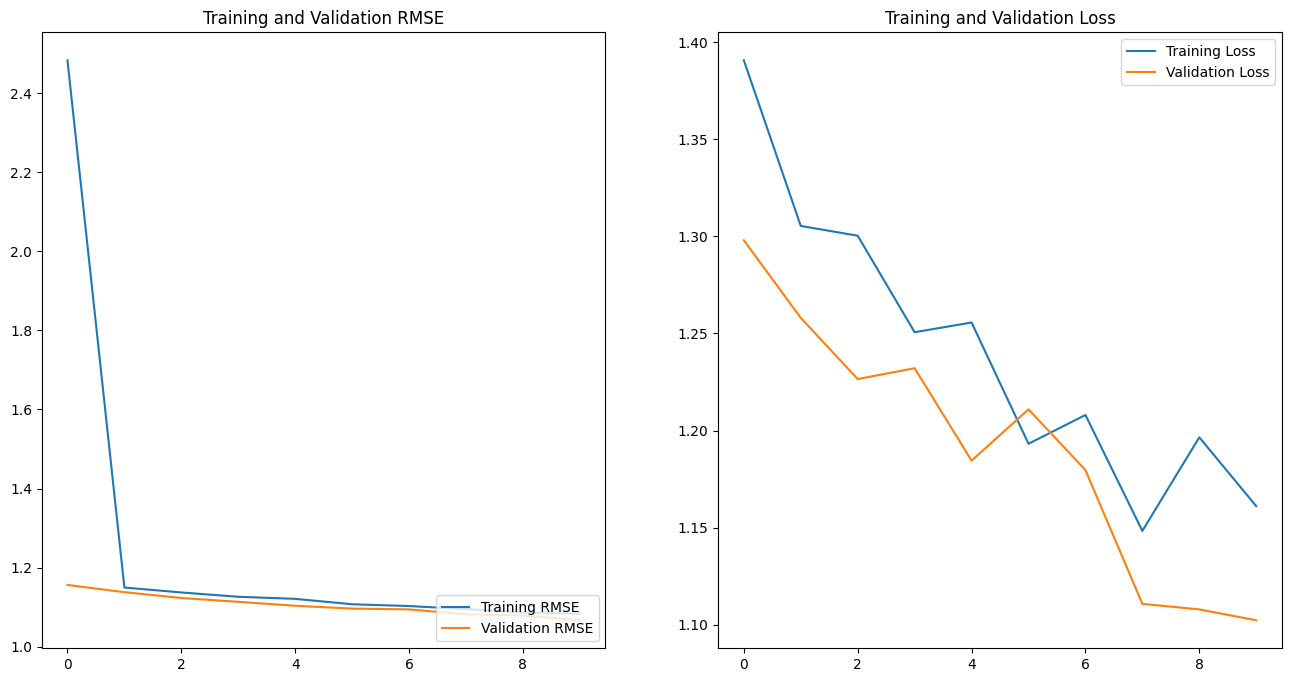

In [122]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training RMSE')
plt.plot(epochs_range, val_rmse, label='Validation RMSE')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Tune hyper parameters
Since transformer ranking model is worse than the simple model, I will tune hyper parameters on the simple model with keras tuner. I try different hidden units and learning rates.

In [ ]:
def build_tuner(hp):
    learning_rate=hp.Choice('learning_rate', [0.1, 0.01])
    dense_units = hp.Choice('dense_units', [1024, 512, 256])
    model = build_model(learning_rate, dense_units)
    return model

tuner = kt.Hyperband(
    build_tuner,
    max_epochs=100,
    project_name='MovieLens',
    objective=kt.Objective("val_root_mean_squared_error", direction="min"))
tuner.search_space_summary(extended=False)
tuner.search(train_dataset, validation_data=test_dataset, epochs=30)

## Conclusion
In the experiment, I train a model on Movielens dataset successful, there are some important tricks.
1. It's important to select features, useful features help improve model performance a lot, but bad features may mislead models.
2. Embeddings could tranfer inputs dimensions into target dimensions and reduce model size.
3. MLP always works as a regression head in ranknig model.

But there are still some aspects worth to explore, such as why transformer model performance is so bad, how can I improve the transformer ranking model performance and try to use classification head in the ranking model.

The ranking model is very intereting and flexiable, so it's worth to spend time on exploring model archs.